In [2]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf

2024-06-04 09:56:12.285358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 09:56:12.285450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 09:56:12.416601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_dir = '/kaggle/input/garbage-classification/garbage_classification'

In [4]:
# Data generators with more aggressive augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2,
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset = 'training'
)

# Flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset = 'validation'
)

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


In [5]:
# Load the mobilenet model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, 
    input_shape=(224, 224, 3), 
    weights='imagenet'
)

# Freeze the mobilenet layers
for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Build the new model on top of mobilenet
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(12, activation='softmax')
])

# Implementing early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=early_stopping,
    verbose=1
)

Epoch 1/30
 2/97 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.1172 - loss: 18.7598 

W0000 00:00:1717497501.521543     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/97 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.4523 - loss: 23.3865

W0000 00:00:1717497583.775622     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5845 - loss: 13.9911

W0000 00:00:1717497695.446333     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.5859 - loss: 13.9025 - val_accuracy: 0.8523 - val_loss: 0.4580
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8319 - loss: 0.5482 - val_accuracy: 0.8600 - val_loss: 0.4225
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.8470 - loss: 0.4861 - val_accuracy: 0.8690 - val_loss: 0.4121
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.8740 - loss: 0.4318 - val_accuracy: 0.8842 - val_loss: 0.3716
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.8703 - loss: 0.4216 - val_accuracy: 0.8797 - val_loss: 0.4003
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8906 - loss: 0.3684 - val_accuracy: 0.8842 - val_loss: 0.3520
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.8820 - loss: 0.3715 - val_accuracy: 0.8855 - val_loss: 0.3672
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8810 - loss: 0.3708 - val_accuracy: 0.8939 - val_loss: 0

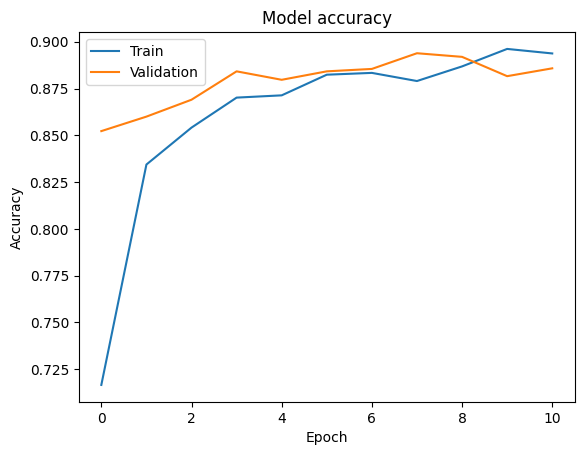

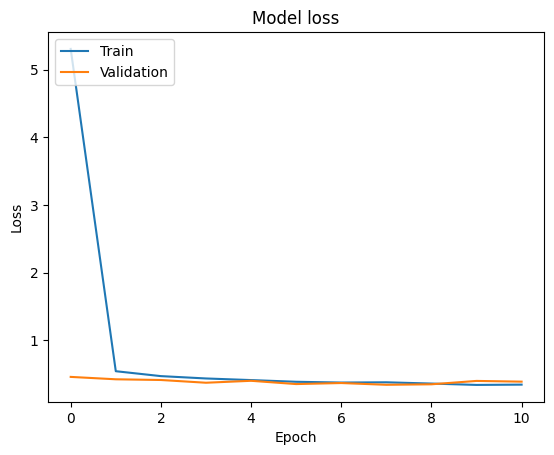

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
# Assume `model` is your trained model
model_save_path = "/kaggle/working/model.h5"
saved_model_export_path = "/kaggle/working/saved_model"

# Save the model in .h5 format
model.save(model_save_path)

# Export the model to SavedModel format
model.export(saved_model_export_path)

# Convert the SavedModel to TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_export_path)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
tflite_model_save_path = "/kaggle/working/model.tflite"
with open(tflite_model_save_path, "wb") as f:
    f.write(tflite_model)

print(f"Model saved in .h5 format at: {model_save_path}")
print(f"Model exported to SavedModel format at: {saved_model_export_path}")
print(f"TensorFlow Lite model saved at: {tflite_model_save_path}")

Saved artifact at '/kaggle/working/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_160')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  139383971321584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139383971324400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139383971326512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139383971324752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139383971324224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139383971329504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139383971514848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139383971514496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139383971512384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139383971512912: TensorSpec(shape=(), dtype=tf.resource, name=None)


Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 110, Total Ops 183, % non-converted = 60.11 %
 * 110 ARITH ops

- arith.constant:  110 occurrences  (f32: 108, i32: 2)



  (f32: 10)
  (f32: 35)
  (f32: 17)
  (f32: 2)
  (f32: 4)
  (f32: 1)
  (f32: 1)


Model saved in .h5 format at: /kaggle/working/model.h5
Model exported to SavedModel format at: /kaggle/working/saved_model
TensorFlow Lite model saved at: /kaggle/working/model.tflite
